In [2]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from itertools import product
import numpy as np
import numba as nb
import imageio
import os
import shutil

randomSeed = 100

%matplotlib inline
%config InlineBackend.figure_format = "svg"

new_cmap = mcolors.LinearSegmentedColormap.from_list(
    "new", plt.cm.jet(np.linspace(0, 1, 256)) * 0.85, N=256
)

@nb.njit
def colors_idx(phaseTheta):
    return np.floor(256 - phaseTheta / (2 * np.pi) * 256).astype(np.int32)

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

import seaborn as sns

sns.set(font_scale=1.1, rc={
    'figure.figsize': (10, 6),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#000000',
    'figure.titleweight': "bold",
    'xtick.color': '#000000',
    'ytick.color': '#000000'
})

In [3]:
class Swarmalators2D():
    def __init__(self, agentsNum: int, dt: float, K: float) -> None:
        np.random.seed(randomSeed)
        self.positionX = np.random.random((agentsNum, 2)) * 2 - 1
        self.phaseTheta = np.random.random(agentsNum) * 2 * np.pi
        self.agentsNum = agentsNum
        self.dt = dt
        self.K = K

    @staticmethod
    @nb.njit
    def _delta_theta(phaseTheta):
        dim = phaseTheta.shape[0]
        subTheta = phaseTheta - np.repeat(phaseTheta, dim).reshape(dim, dim)

        deltaTheta = np.zeros((dim, dim - 1))
        for i in np.arange(dim):
            deltaTheta[i, :i], deltaTheta[i, i:] = subTheta[i, :i], subTheta[i, i + 1 :]
        return deltaTheta

    @staticmethod
    @nb.njit
    def _delta_x(positionX):
        dim = positionX.shape[0]
        subX = positionX - np.repeat(positionX, dim).reshape(dim, 2, dim).transpose(0, 2, 1)
        deltaX = np.zeros((dim, dim - 1, 2))
        for i in np.arange(dim):
            deltaX[i, :i], deltaX[i, i:] = subX[i, :i], subX[i, i + 1 :]
        return deltaX

    @staticmethod
    @nb.njit
    def distance_x_2(deltaX):
        return np.sqrt(deltaX[:, :, 0] ** 2 + deltaX[:, :, 1] ** 2).reshape(deltaX.shape[0], deltaX.shape[1], 1)

    @staticmethod
    @nb.njit
    def distance_x(deltaX):
        return np.sqrt(deltaX[:, :, 0] ** 2 + deltaX[:, :, 1] ** 2)

    @property
    def deltaTheta(self) -> np.ndarray:
        """Phase difference between agents"""
        return self._delta_theta(self.phaseTheta)

    @property
    def deltaX(self) -> np.ndarray:
        """Spatial difference between agents"""
        return self._delta_x(self.positionX)

    @property
    def Fatt(self) -> np.ndarray:
        """Effect of phase similarity on spatial attraction"""
        pass

    @property
    def Frep(self) -> np.ndarray:
        """Effect of phase similarity on spatial repulsion"""
        pass

    @property
    def Iatt(self) -> np.ndarray:
        """Spatial attraction"""
        pass

    @property
    def Irep(self) -> np.ndarray:
        """Spatial repulsion"""
        pass

    @property
    def H(self) -> np.ndarray:
        """Phase interaction"""
        pass

    @property
    def G(self) -> np.ndarray:
        """Effect of spatial similarity on phase couplings"""
        pass

    @property
    def velocity(self) -> np.ndarray:
        """Self propulsion velocity"""
        pass

    @property
    def omega(self) -> np.ndarray:
        """Natural intrinsic frequency"""
        pass

    @staticmethod
    @nb.njit
    def _update(
        positionX: np.ndarray, phaseTheta: np.ndarray,
        velocity: np.ndarray, omega: np.ndarray,
        Iatt: np.ndarray, Irep: np.ndarray,
        Fatt: np.ndarray, Frep: np.ndarray,
        H: np.ndarray, G: np.ndarray,
        K: float, dt: float
    ):
        dim = positionX.shape[0]
        pointX = velocity + np.sum(
            Iatt * Fatt.reshape((dim, dim - 1, 1)) - Irep * Frep.reshape((dim, dim - 1, 1)),
            axis=1
        ) / (dim - 1)
        positionX += pointX * dt
        pointTheta = omega + K * np.sum(H * G, axis=1) / (dim - 1)
        phaseTheta = np.mod(phaseTheta + pointTheta * dt, 2 * np.pi)
        return positionX, phaseTheta
    

    def update(self) -> None:
        self.positionX, self.phaseTheta = self._update(
            self.positionX, self.phaseTheta,
            self.velocity, self.omega,
            self.Iatt, self.Irep,
            self.Fatt, self.Frep,
            self.H, self.G,
            self.K, self.dt
        )

    def plot(self) -> None:
        plt.figure(figsize=(6, 5))

        plt.scatter(self.positionX[:, 0], self.positionX[:, 1],
                    c=self.phaseTheta, cmap=new_cmap, alpha=0.8, vmin=0, vmax=2*np.pi)

        cbar = plt.colorbar(ticks=[0, np.pi, 2*np.pi])
        cbar.ax.set_ylim(0, 2*np.pi)
        cbar.ax.set_yticklabels(['$0$', '$\pi$', '$2\pi$'])

In [4]:
class RingStatesSwarmalators(Swarmalators2D):
    def __init__(self, agentsNum: int, dt: float, K: float, 
                 J1: float, J2: float) -> None:
        super().__init__(agentsNum, dt, K)
        self.J1 = J1
        self.J2 = J2 * np.ones((agentsNum, agentsNum - 1))
        self.A = 1
        self.B = np.ones((agentsNum, agentsNum - 1))
        self.omegaValue = 0
        self.velocityValue = 0

    @property
    def omega(self) -> np.ndarray:
        return self.omegaValue

    @property
    def velocity(self) -> np.ndarray:
        """Self propulsion velocity"""
        return self.velocityValue
    
    @property
    def Fatt(self) -> np.ndarray:
        """
        Effect of phase similarity on spatial attraction
        A + J1 * cos(theta_j - theta_i)
        """
        return self.A + self.J1 * np.cos(self.deltaTheta)
    
    @property
    def Frep(self) -> np.ndarray:
        """Effect of phase similarity on spatial repulsion: 
        B - J2 * cos(theta_j - theta_i)"""
        return self.B - self.J2 * np.cos(self.deltaTheta)

    @property
    def Iatt(self) -> np.ndarray:
        """Spatial attraction: (x_j - x_i)"""
        return self.deltaX
    
    @property
    def Irep(self) -> np.ndarray:
        """Spatial repulsion: (x_j - x_i) / |x_j - x_i| ^ 2"""
        return self.deltaX / self.distance_x_2(self.deltaX) ** 2

    @property
    def H(self) -> np.ndarray:
        """Phase interaction: sin(theta_j - theta_i)"""
        return np.sin(self.deltaTheta)
    
    @property
    def G(self) -> np.ndarray:
        """Effect of spatial similarity on phase couplings: 1 / |x_i - x_j| ^ 2"""
        return 1 / self.distance_x(self.deltaX) ** 2

In [5]:
def plot_2d_model(positionX, phaseTheta, 
                #   velocity, 
                  xlim, ylim, title):
    plt.figure(figsize=(6, 5))

    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['font.family'] = 'STIXGeneral'

    
    
    # plt.quiver(positionX[:, 0], positionX[:, 1], velocity[:, 0], velocity[:, 1],
    #            color=[new_cmap(i) for i in colors_idx(phaseTheta)], alpha=0.8, scale=15, width=0.005)
    plt.scatter(positionX[:, 0], positionX[:, 1],
                c=phaseTheta, cmap=new_cmap, alpha=0.8, vmin=0, vmax=2*np.pi, s=3)
    cbar = plt.colorbar(ticks=[0, np.pi, 2 * np.pi])
    cbar.ax.set_ylim(0, 2* np.pi)
    cbar.ax.set_yticklabels(['$0$', '$\pi$', '$2\pi$'])
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title(title)

In [6]:
model = RingStatesSwarmalators(agentsNum=100, dt=0.1, K=-0.003, J1=0, J2=1)

if os.path.exists("RingPhaseWavesImages"):
    shutil.rmtree("RingPhaseWavesImages")
os.mkdir("RingPhaseWavesImages")

positions = []
phases = []

for i in tqdm(range(1000)):
    model.update()
    if i % 5 == 0:
        positions.append(model.positionX.copy())
        phases.append(model.phaseTheta.copy()) 

xOfPositions = np.array(positions)[:, :, 0]
yOfPositions = np.array(positions)[:, :, 1]
xlim = (np.min(xOfPositions), np.max(xOfPositions))
ylim = (np.min(yOfPositions), np.max(yOfPositions))
images = []

for i, (position, phase) in tqdm(enumerate(zip(positions, phases)), total=len(positions)):
    plot_2d_model(position, phase, xlim, ylim, f"t={i * 0.5}")
    plt.savefig(f"RingPhaseWavesImages/{i}.png", dpi=200)
    plt.close()
    images.append(imageio.imread(f"RingPhaseWavesImages/{i}.png"))

imageio.mimsave("RingPhaseWaves.gif", images, fps=20)

# ffmpeg trans gif to mp4
# os.system("ffmpeg -i RingPhaseWaves.gif RingPhaseWaves.mp4")

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
"RingPhaseWaves"
RingStatesSwarmalators(agentsNum=100, dt=0.1, K=-0.003, J1=0, J2=1)

"AnnularPhaseWaves"
RingStatesSwarmalators(agentsNum=2*10**3, dt=0.1, K=0, J1=0.5, J2=1)

"AnnularPhaseWavesJreverse"
RingStatesSwarmalators(agentsNum=2*10**3, dt=0.1, K=0, J1=1, J2=0.5)

"SplinteredPhaseWaves"
RingStatesSwarmalators(agentsNum=1000, dt=0.1, K=-0.05, J1=1.5, J2=0)

"SplinteredPhaseWavesJreverse"
RingStatesSwarmalators(agentsNum=1000, dt=0.1, K=-0.05, J1=0, J2=1.5)

"AnnularPhaseWavesJreverse"
RingStatesSwarmalators(agentsNum=2*10**3, dt=0.1, K=0, J1=1, J2=0.5)

"HopfBifurcation"
RingStatesSwarmalators(agentsNum=1000, dt=0.1, K=-3.4, J1=1.7, J2=0)

In [18]:
os.system("ffmpeg -i AnnularPhaseWaves.gif AnnularPhaseWaves.mp4")

0

In [26]:
name = "SplinteredPhaseWavesJreverse"
model = RingStatesSwarmalators(agentsNum=1000, dt=0.1, K=-0.05, J1=0, J2=1.5)

if os.path.exists(f"{name}Images"):
    shutil.rmtree(f"{name}Images")
os.mkdir(f"{name}Images")

positions = []
phases = []

for i in tqdm(range(1000)):
    model.update()
    if i % 5 == 0:
        positions.append(model.positionX.copy())
        phases.append(model.phaseTheta.copy()) 

xOfPositions = np.array(positions)[:, :, 0]
yOfPositions = np.array(positions)[:, :, 1]
# xlim = ylim = (-5, 5)
xlim = (np.min(xOfPositions), np.max(xOfPositions))
ylim = (np.min(yOfPositions), np.max(yOfPositions))
images = []

for i, (position, phase) in tqdm(enumerate(zip(positions, phases)), total=len(positions)):
    plot_2d_model(position, phase, xlim, ylim, f"t={i * 0.5}")
    plt.savefig(f"{name}Images/{i}.png", dpi=200)
    plt.close()
    images.append(imageio.imread(f"{name}Images/{i}.png"))

imageio.mimsave(f"{name}.gif", images, fps=20)

# ffmpeg trans gif to mp4
if os.path.exists(f"{name}.mp4"):
    os.remove(f"{name}.mp4")
os.system(f"ffmpeg -i {name}.gif {name}.mp4")

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

0

In [50]:
for _ in tqdm(range(100)):
    model.update()

  0%|          | 0/100 [00:00<?, ?it/s]

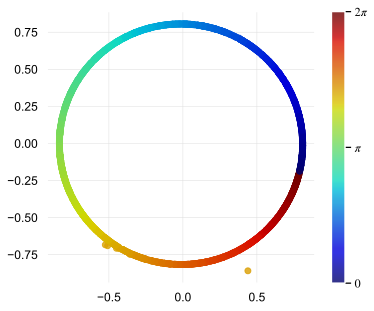

In [51]:
model.plot()